In [1]:
import Pkg
Pkg.activate("../../Tasks2D")

  Activating project at `~/Developer/tasks2D/Tasks2D`


In [195]:
using Revise      # For development; makes it so modifications
                  # to imported modules are immediately reflected in this Julia session

import LineWorlds # Local module with code for 2D maps where
                  # the primitive objects are line segments.
const L = LineWorlds
const Geo = L.Geometry;

In [196]:
# Load function to construct a "hotel" map with a given number
# of identical rooms.
includet("01/hotel_env.jl")

# Construct a hotel environment with 4 rooms.
(walls, bounding_box) = construct_hotel_env(4);
rooms = get_hotel_rooms(4);

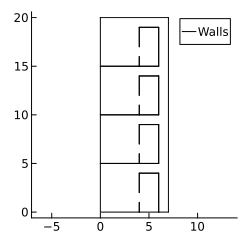

In [197]:
using Plots
plot(size=(250, 250), aspect_ratio=:equal, grid=false)
plot!(walls, c=:black, label="Walls")

In [198]:
function rect_to_segs((b, l), (w, h))
    return L.Segment.(Vector{Float64}[
        [b, l, b + w, l],
        [b + w, l, b + w, l + h],
        [b + w, l + h, b, l + h],
        [b, l + h, b, l]
    ])
end
room_segs = vcat([rect_to_segs(room.bl, room.wh) for room in rooms]...)

square_rooms = _rooms(4)
sq_room_segs = vcat([rect_to_segs(room.bl, room.wh) for room in square_rooms]...)

16-element Vector{LineWorlds.Geometry.Segment}:
 LineWorlds.Geometry.Segment([0.0, 0.0], [4.0, 0.0])
 LineWorlds.Geometry.Segment([4.0, 0.0], [4.0, 5.0])
 LineWorlds.Geometry.Segment([4.0, 5.0], [0.0, 5.0])
 LineWorlds.Geometry.Segment([0.0, 5.0], [0.0, 0.0])
 LineWorlds.Geometry.Segment([0.0, 5.0], [4.0, 5.0])
 LineWorlds.Geometry.Segment([4.0, 5.0], [4.0, 10.0])
 LineWorlds.Geometry.Segment([4.0, 10.0], [0.0, 10.0])
 LineWorlds.Geometry.Segment([0.0, 10.0], [0.0, 5.0])
 LineWorlds.Geometry.Segment([0.0, 10.0], [4.0, 10.0])
 LineWorlds.Geometry.Segment([4.0, 10.0], [4.0, 15.0])
 LineWorlds.Geometry.Segment([4.0, 15.0], [0.0, 15.0])
 LineWorlds.Geometry.Segment([0.0, 15.0], [0.0, 10.0])
 LineWorlds.Geometry.Segment([0.0, 15.0], [4.0, 15.0])
 LineWorlds.Geometry.Segment([4.0, 15.0], [4.0, 20.0])
 LineWorlds.Geometry.Segment([4.0, 20.0], [0.0, 20.0])
 LineWorlds.Geometry.Segment([0.0, 20.0], [0.0, 15.0])

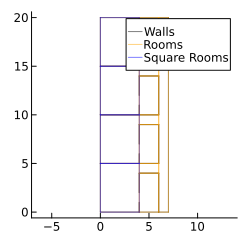

In [199]:
using Plots
plot(size=(250, 250), aspect_ratio=:equal, grid=false)
plot!(walls, c=:black, linealpha=0.5, label="Walls")
plot!(room_segs, c=:orange, linealpha=0.5, label="Rooms")
plot!(sq_room_segs, c=:blue, linealpha=0.5, label="Square Rooms")

In [200]:
#=

=#

In [201]:
using Gen

In [202]:
### Ground truth world model parameters ###
PARAMS = (;
    map = walls,
    p_kidnapped = 0.,
    bounding_box = bounding_box,
    all_rooms = rooms,
    viable_rooms=square_rooms,
    target_pose_relative_to_room=[1., 1.],
    step = (; Δ = 0.25, σ = 0.005 ), # step model arguments
    obs = (; fov = 2π, n_rays = 80,  # obs model arguments
        orientation=π/2,
        sensor_args = (;
            w = 5, s_noise = 0.02,
            outlier = 0.0001, outlier_vol = 100.0,
            zmax = 100.0
)));

In [203]:
@dist labeled_categorical(labels, probs) = labels[categorical(probs)]

Gen.CompiledDistWithArgs{Any}(Gen.WithLabelArg{Any, Int64}(Gen.Categorical()), 2, Bool[0, 1], (Gen.SimpleArg{Any}(1), Gen.SimpleArg{Any}(2)))

In [204]:
### Initial state distribution ###

mvuniform = L.ProductDistribution(uniform);
@gen function world_initial_model(params)

    # Agent pos
    mins, maxs = params.bounding_box
    pos ~ mvuniform(mins, maxs)

    # Which room is the target object in?
    target_room ~ labeled_categorical(params.viable_rooms, [1/length(params.viable_rooms) for _ in params.viable_rooms])
    
    # POMDP state: agent position; which room the target object is in
    return (; pos, target_room)
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##world_initial_model#5742", Bool[0], false)

In [205]:
includet("../../notebooks_clean/KidnappedRobot/motion_model_utils.jl")

@gen function motion_model(prev_pos, action, params)
    # Move the agent up/down/left/right by params.step.Δ units.
    np = det_next_pos(prev_pos, action, params.step.Δ)
        
    # Have an affordance in the model for the agent to randomly
    # re-locate to a new position.
    is_kidnapped ~ bernoulli(params.p_kidnapped)

    if !is_kidnapped
        # In normal operation, the agent moves to `np`, plus
        # a bit of stochastic noise.
        pos ~ broadcasted_normal(np, params.step.σ)

        # If `np` plus the noise
        # would have the agent collide with a wall, the agent
        # halts preemptively.
        next_pos = handle_wall_intersection(prev_pos, pos, params.map)

    else
        # If the robot was kidnapped, it could appear anywhere.
        # {*} syntax inlines the random choices (here, `:pos`) from the
        # `uniform_agent_pos` generative function into this one.
        next_pos = {*} ~ uniform_agent_pos(params)
    end

    return next_pos
end

# Motion model accepts the previous world state (the agent's previous position)
# and an action in [:up, :down, :left, :right, :stay]
@gen function world_step_model(prev_state, action, params)
    (prev_pos, target_room) = prev_state
    next_pos = {*} ~ motion_model(prev_pos, action, params)
    return (next_pos, target_room)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##world_step_model#5744", Bool[0, 0, 0], false)

In [206]:
### Observation model ###

# Load: `get_sensor_args`; `sensordist_2dp3`.
includet("../../notebooks_clean/KidnappedRobot/sensor_model_utils.jl")

function get_sensor_args(pos, params, segs)
    p = L.Pose(pos, params.obs.orientation)
    w, s_noise, outlier, outlier_vol, zmax = params.obs.sensor_args
    _as = L.create_angles(params.obs.fov, params.obs.n_rays)
    zs = L.cast([p], segs; num_a=params.obs.n_rays, zmax)
    ỹ  = L.get_2d_mixture_components(zs, _as, w; fill_val_z=zmax)[1,:,:,:]

    return (ỹ, s_noise, outlier, outlier_vol)
end

# This observation model generates noisy LIDAR measurements
# from the agent to the surrounding walls.
# See the visuals below.
@gen function world_sensor_model(state, params)
    (pos, target_room) = state

    # Place the target object in the target room,
    # and get the overall collection of line segments making up the environment
    # (containing both the environment "map" [walls], and the target object).
    target_object_segments = segments_for_object_in(target_room, params.target_pose_relative_to_room)
    env_segments = vcat(params.map, target_object_segments)
    sensor_args = get_sensor_args(pos, params, env_segments)

    obs ~ L.sensordist_2dp3(sensor_args...)
    return obs
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##world_sensor_model#5745", Bool[0, 0], false)

In [207]:
import GenPOMDPs

In [208]:
# POMDP of this environment
world_pomdp = GenPOMDPs.GenPOMDP(
    world_initial_model,     # INIT   : params                      ⇝ state
    world_step_model,        # STEP   : prev_state, action, params  ⇝ state
    world_sensor_model,      # OBS    : state, params               ⇝ observation
    (state, action) -> -1.   # UTILITY: state, action, params       → utility
                             # "⇝" denotes a Generative Function; "→" denotes a (guaranteed deterministic) function
)

GenPOMDPs.GenPOMDP(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##world_initial_model#5742", Bool[0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##world_step_model#5744", Bool[0, 0, 0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##world_sensor_model#5745", Bool[0, 0], false), var"#370#371"())

### Agent's mental model of the environment

In [211]:
# Import immutable dictionary data structure.
import FunctionalCollections: PersistentArrayMap, assoc

In [212]:
@gen function mental_initial_model(params)
    # Agent pos
    mins, maxs = params.bounding_box
    pos ~ mvuniform(mins, maxs)

    room_placements = PersistentArrayMap{Any, Any}()
    
    # POMDP state: agent position; which room the target object is in;
    # whether we sampled a new room placement this step.
    # For now, we assume we always spawn in a room where the object is _not_, so we will be
    # able to localize without knowing where the object is.
    return (pos, room_placements)
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##mental_initial_model#5746", Bool[0], false)

In [213]:
@gen function extend_placements(pos, room_placements, params)
    room = room_containing(pos, params)
    if haskey(room_placements, room) || !(room in params.viable_rooms)
        return (room_placements, false)
    end

    p_in_room = (1 - params.p_no_object) / (length(params.viable_rooms) - length(room_placements))
    object_is_in_room ~ bernoulli(p_in_room)

    newmap = assoc(room_placements, room, object_is_in_room)
    
    return (newmap, true)
end

@gen function mental_step_model(state, action, params)
    (pos, room_placements) = state

    next_pos = {*} ~ motion_model(pos, action, params)
    extended_placements ~ extend_placements(next_pos, room_placements, params)
    (new_room_placements, new_placement_decided) = extended_placements
    
    return (next_pos, new_room_placements)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##mental_step_model#5748", Bool[0, 0, 0], false)

In [214]:
@gen function mental_sensor_model(state, params)
    (pos, room_placements) = state

    if target_object_placed(room_placements)
        target_room = get_target_room(room_placements)
        target_object_segments = segments_for_object_in(target_room, params.target_pose_relative_to_room)
        env_segments = vcat(params.map, target_object_segments)
    else
        env_segments = params.map
    end

    sensor_args = get_sensor_args(pos, params, env_segments)
    obs ~ L.sensordist_2dp3(sensor_args...)
    return obs
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##mental_sensor_model#5749", Bool[0, 0], false)

In [215]:
mental_pomdp = GenPOMDPs.GenPOMDP(
    mental_initial_model,    # INIT   : params                      ⇝ state
    mental_step_model,       # STEP   : prev_state, action, params  ⇝ state
    mental_sensor_model,     # OBS    : state, params               ⇝ observation
    (state, action) -> -1.   # UTILITY: state, action, params       → utility
                             # "⇝" denotes a Generative Function; "→" denotes a (guaranteed deterministic) function
)

GenPOMDPs.GenPOMDP(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##mental_initial_model#5746", Bool[0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##mental_step_model#5748", Bool[0, 0, 0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##mental_sensor_model#5749", Bool[0, 0], false), var"#372#373"())

In [217]:
# Code for the agent's reasoning about room room_placements

target_object_placed(room_placements) = any(values(room_placements))
get_target_room(room_placements) = findfirst(room_placements)

function in_room(pos, room)
    (xmin, ymin), (w, h) = room
    xmax, ymax = xmin + w, ymin + h
    x, y = pos
    return xmin <= x <= xmax && ymin <= y <= ymax
end
function room_containing(pos, params)
    for room in params.all_rooms
        if in_room(pos, room)
            return room
        end
    end
    error("Position $pos is not in any room")
end
function room_center(room)
    (xmin, ymin), (w, h) = room
    return (xmin + w/2, ymin + h/2)
end
function taxi_dist_to_room_center(pos, room)
    (x, y) = pos
    (cx, cy) = room_center(room)
    return abs(x - cx) + abs(y - cy)
end
function nearest_unexplored_room(pos, params, room_placements)
    nearest_room = nothing
    nearest_dist = Inf
    for room in params.viable_rooms
        if haskey(room_placements, room)
            continue
        end
        dist = taxi_dist_to_room_center(pos, room)
        if dist < nearest_dist
            nearest_room = room
            nearest_dist = dist
        end
    end
    return nearest_room
end

function object_pos(room_placements, target_relative_to_pos)
    target_room = get_target_room(room_placements)
    if isnothing(target_room)
        return nothing
    end
    (xmin, ymin), (w, h) = target_room
    (x, y) = target_relative_to_pos
    return (xmin + x, ymin + y)
end

object_pos (generic function with 1 method)

In [218]:
extend_placements

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##extend_placements#5747", Bool[0, 0, 0], false)

In [219]:
# Code for getting the segments corresponding to the target object
function segments_for_object_in(target_room, target_pose_relative_to_room; side_length=.8)
    (l, b) = target_room.bl
    (δx, δy) = target_pose_relative_to_room
    
    # Target object is a square
    return rect_to_segs((l + δx, b + δy), (side_length, side_length))
end

object_pos

object_pos (generic function with 1 method)

In [237]:
include("01/pf.jl")

overwrite_params (generic function with 1 method)

In [238]:
MENTAL_MODEL_PARAMS = overwrite_params(
    (; PARAMS..., p_no_object=0.1,);
    p_kidnapped=0.,
    step=(; σ = 0.1),
    sensor_args=(; s_noise=0.1)
);

In [239]:
update_grid_args, initialization_grid_args = default_pf_args(MENTAL_MODEL_PARAMS; n_particles=1)
localization_pf = @get_localization_pf(mental_pomdp, MENTAL_MODEL_PARAMS, update_grid_args, initialization_grid_args)
(localization_pf_init, localization_pf_update) = localization_pf;

In [240]:
stratified_pf_update = @get_stratified_pf_update(mental_pomdp, MENTAL_MODEL_PARAMS, update_grid_args, initialization_grid_args);

In [241]:
function _update_belief_state(prev_pf_state, prev_action, obs)
    downsized = false;
    upsized = false;

    if isnothing(prev_action) # First timestep
        pf_state = localization_pf_init(choicemap((:obs, obs)))
    else
        pf_state = localization_pf_update(prev_pf_state, prev_action, choicemap((:obs, obs)))

        # if length(pf_state.traces) > 1
        #     t = get_args(pf_state.traces[1])[1]
        #     oldtr1 = prev_pf_state.traces[1]
        #     oldtr2 = prev_pf_state.traces[2]
        #     old_r1 = oldtr1[state_addr(t-1)][2]
        #     old_r2 = oldtr2[state_addr(t-1)][2]

        #     tr1 = pf_state.traces[1]
        #     tr2 = pf_state.traces[2]
        #     r1 = tr1[state_addr(t)][2]
        #     r2 = tr2[state_addr(t)][2]
        #     @assert r1 != r2 "r1 = $r1, r2 = $r2 ; old_r1 = $old_r1, old_r2 = $old_r2"
        # end
        
        # If the agent has moved into a new room, then generate 2 particles,
        # one with the target object in the new room, and one without the target
        # object
        if length(pf_state.traces) == 1

            new_tr = pf_state.traces[1]
            t = get_args(new_tr)[1]
            new_room_plmts = new_tr[state_addr(t)][2]
            old_room_plmts = prev_pf_state.traces[1][state_addr(t-1)][2]

            if !target_object_placed(old_room_plmts) && length(new_room_plmts) > length(old_room_plmts)
                # println("upsizing... -- t = $t")

                pf_state = copy(prev_pf_state)
                GenParticleFilters.pf_resize!(pf_state, 2)
                pf_state = stratified_pf_update(pf_state, prev_action, choicemap((:obs, obs)), t)
                upsized = true
                # println("upsized.")
                @assert get_args(pf_state.traces[1])[1] == t

                # tr1 = pf_state.traces[1]
                # tr2 = pf_state.traces[2]
                # r1 = tr1[state_addr(t)][2]
                # r2 = tr2[state_addr(t)][2]
                # @assert r1 != r2 "r1 = $r1, r2 = $r2"
            end
        
        else
            @assert length(pf_state.traces) > 1
            # If we are maintaining two hypotheses, but one of them is almost
            # certainly right, discard the other.
            
            weights = GenParticleFilters.get_norm_weights(pf_state)
            maxw = maximum(weights);
            if maxw > .9995
                GenParticleFilters.pf_resize!(pf_state, 1, :residual)
                downsized = true
            else
                # new_tr = pf_state.traces[1]
                # t = get_args(new_tr)[1]
                # # println("not downsizing.  t = $t ; maxw = $maxw")

                # tr1 = pf_state.traces[1]
                # tr2 = pf_state.traces[2]
                # r1 = tr1[state_addr(t)][2]
                # r2 = tr2[state_addr(t)][2]
                # println("beliefs: $r1 ; $r2")
            end
        end
    end

    return (pf_state, downsized, upsized)
end

_update_belief_state (generic function with 1 method)

In [242]:
includet("../../notebooks_clean/KidnappedRobot/astar_planning.jl")
includet("01/handle_sticking.jl")

In [243]:
# Generate a gridworld version of this environment, in which A* planning is feasible.
planning_params = get_planning_params(walls, bounding_box);

In [244]:
@gen function _controller(cstate, obs)
    (prev_pf_state, prev_action, room_to_explore) = cstate

    ### Update the approximate belief state ###
    (pf_state, downsized, upsized) = _update_belief_state(prev_pf_state, prev_action, obs)

    ### Actions ###
    new_tr = pf_state.traces[1]
    t = get_args(new_tr)[1]
    room_placements = new_tr[state_addr(t)][2]

    # If we are basically sure where the object is -- gridsearch to it.
    if length(pf_state.traces) == 1 && target_object_placed(room_placements)
        # Choose action
        goal = object_pos(room_placements, MENTAL_MODEL_PARAMS.target_pose_relative_to_room)
        room_to_explore = nothing # We are done exploring; we know where the target object is
    else
        if downsized || #= first step check: =# isnothing(prev_action) 
            # This means we have sufficiently explored the current room, so pick a new room to explore.
            room_to_explore = nearest_unexplored_room(currentpos(new_tr), MENTAL_MODEL_PARAMS, room_placements)
        end

        # Go to the center of the room to explore
        goal = room_center(room_to_explore)
    end

    goal = [goal[1], goal[2]]
    action = find_action_using_grid_search(planning_params, currentpos(new_tr), Vector(goal))::Symbol
    action = handle_sticking(prev_pf_state, prev_action, pf_state, action)::Symbol
    
    return (action, (pf_state, action, room_to_explore))
end

controller = GenPOMDPs.Controller(_controller, (nothing, nothing, nothing))

GenPOMDPs.Controller(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##_controller#6374", Bool[0, 0], false), (nothing, nothing, nothing))

In [246]:
includet("01/visualization.jl")

In [247]:
rollout_model = GenPOMDPs.RolloutModel(world_pomdp, controller)

GenPOMDPs.var"##StaticGenFunction__RolloutModel#6443"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [248]:
# Start the agent off in a hallway.
INITIAL_POS = [6.5, 4*5 - 2];
INITIAL_ROOM = square_rooms[1];

rollout_tr = Gen.generate(rollout_model, (0, PARAMS), 
    choicemap(
        (GenPOMDPs.state_addr(0, :pos), INITIAL_POS),
        (GenPOMDPs.state_addr(0, :target_room), INITIAL_ROOM)
    )
)[1];

┌ Info: Saved animation to /tmp/jl_e1w7wRUdud.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_e1w7wRUdud.gif")
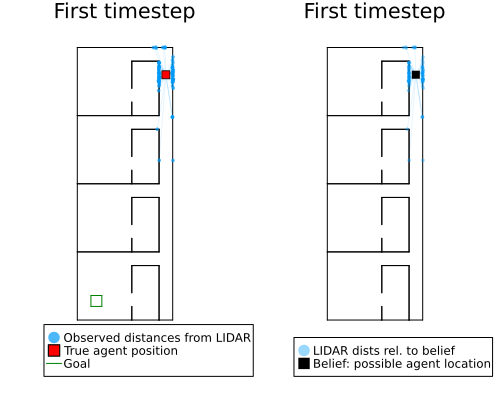

In [249]:
trace_to_gif(rollout_tr, title="First timestep")

In [254]:
rollout_tr, _ = Gen.update(rollout_tr,  # Update the record of the rollout...
    (180, PARAMS),                                          # ...updating it to a rollout of 100 steps, with the same PARAMS as before...
    (UnknownChange(), NoChange()),                        # ...noting that the time argument changed, and the params didn't
                                                          #    (so Gen knows not to revisit every choice depending on PARAMS)...
    EmptyChoiceMap()                                      # Don't constrain any of the randomness in the roll-out.
                                                          # (In principle, we could use this last argument to constrain either environmental
                                                          # randomness, or random choices made by the controller in the roll-out.)
);

adding room placement constraint at time 16


adding room placement constraint at time 58


adding room placement constraint at time 100


adding room placement constraint at time 142


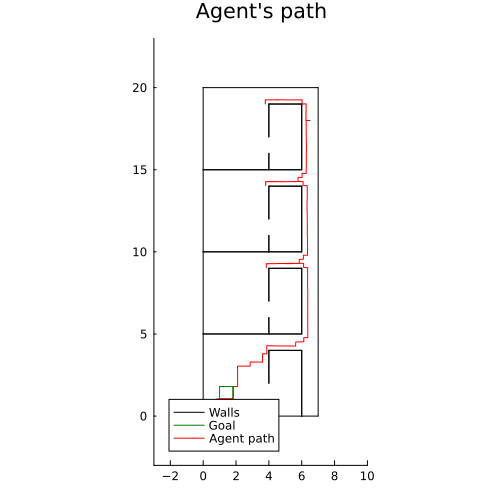

In [255]:
# Visualize the path the agent took.
trace_to_path_image(rollout_tr)

┌ Info: Saved animation to /tmp/jl_2RqnGZAJSh.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_2RqnGZAJSh.gif")
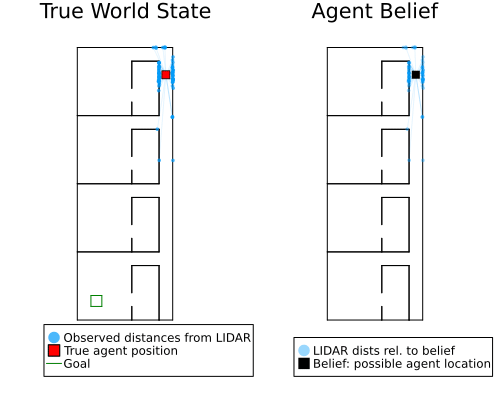

In [256]:
trace_to_gif(rollout_tr; fps=10, min_display_weight=.1)

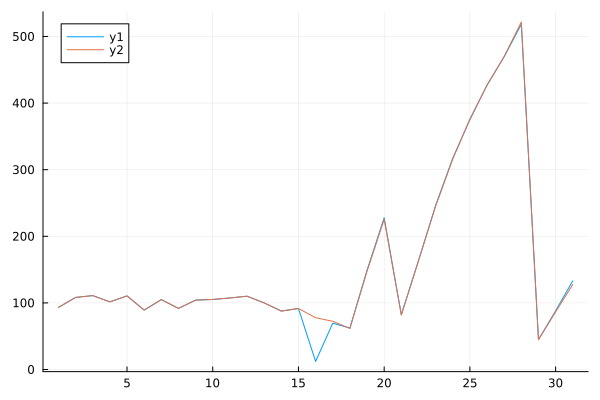

In [522]:
nparticles = [
    length(pf_state.traces) for (_, (pf_state, _, _)) in GenPOMDPs.control_sequence(rollout_tr)
]
weights1 = [
    # GenParticleFilters.get_norm_weights(pf_state)[1]
    pf_state.log_weights[1]
    for (_, (pf_state, _, _)) in GenPOMDPs.control_sequence(rollout_tr)
]
weights2 = [
    pf_state.log_weights[length(pf_state.traces) > 1 ? 2 : 1] 
    for (_, (pf_state, _, _)) in GenPOMDPs.control_sequence(rollout_tr)
]

# plot(1:length(nparticles), nparticles)
plot(1:length(weights1), weights1)
plot!(1:length(weights2), weights2)

In [388]:
maximum(nparticles)

2

In [526]:
(_, (pf_state, _, _)) = GenPOMDPs.control_sequence(rollout_tr)[16];
GenPOMDPs.state_sequence(pf_state.traces[1])[end][2]

Persistent{Any, Any}Pair{Any, Any}[(bl = [0, 15], wh = [4, 5]) => true]

In [360]:
GenPOMDPs.state_sequence(pf_state.traces[2])[end][2]

Persistent{Any, Any}Pair{Any, Any}[(bl = [0, 15], wh = [4, 5]) => false, (bl = [0, 10], wh = [4, 5]) => false, (bl = [0, 5], wh = [4, 5]) => false]

┌ Info: Saved animation to /tmp/jl_GhO1Wd8Z8L.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_GhO1Wd8Z8L.gif")
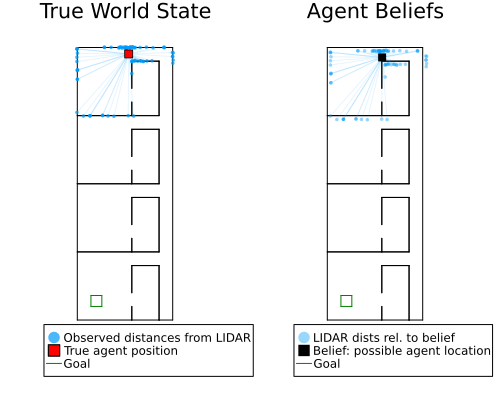

In [363]:
trace_to_gif(rollout_tr, 17, 17, fps=10)

In [283]:
(_, (pf_state, _, _)) = GenPOMDPs.control_sequence(rollout_tr)[argmax(nparticles)];
s = get_selected(get_choices(pf_state.traces[1]), select((state_addr(t, :extended_placements) for t=1:100)...))
display(s)

In [165]:
state_addr(1, :extend_placements)

:steps => (1 => (:state => :extend_placements))

In [350]:
params.rooms

UndefVarError: UndefVarError: params not defined

In [516]:
GenParticleFilters.pf_resize!

pf_resize! (generic function with 2 methods)